# XGBoost

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load training data
X_train = pd.read_csv('/kaggle/input/qcd-tt-jet-tagging-hsf-india-bangalore/train/features/cluster_features.csv')
y_train = np.load('/kaggle/input/qcd-tt-jet-tagging-hsf-india-bangalore/train/labels/labels.npy')

# Load validation data
X_val = pd.read_csv('/kaggle/input/qcd-tt-jet-tagging-hsf-india-bangalore/val/features/cluster_features.csv')
y_val = np.load('/kaggle/input/qcd-tt-jet-tagging-hsf-india-bangalore/val/labels/labels.npy')

# Load test data (no labels)
X_test = pd.read_csv('/kaggle/input/qcd-tt-jet-tagging-hsf-india-bangalore/test/features/cluster_features.csv')
test_ids = np.load('/kaggle/input/qcd-tt-jet-tagging-hsf-india-bangalore/test/ids/ids.npy')


In [3]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# Initialize and train the model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

# Predict probabilities on validation set
val_preds_xgb = xgb.predict_proba(X_val)[:, 1]

# Calculate AUC
auc_xgb = roc_auc_score(y_val, val_preds_xgb)
print(f"Validation AUC (XGBoost): {auc_xgb:.4f}")

Validation AUC (XGBoost): 0.9341


In [4]:
np.save("01_xgb_val_preds.npy", val_preds_xgb)

test_xgb_preds = xgb.predict_proba(X_test)[:, 1]
np.save('/kaggle/working/01_xgb_test_preds.npy', test_xgb_preds)

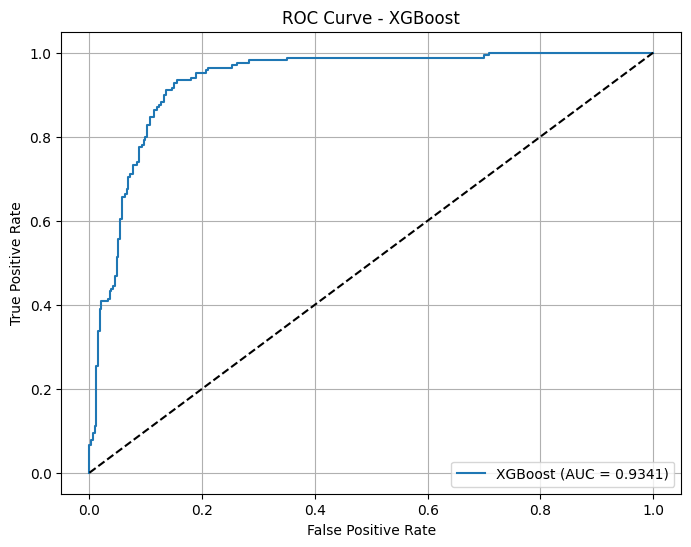

In [5]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr_xgb, tpr_xgb, _ = roc_curve(y_val, val_preds_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend()
plt.grid(True)
plt.show()

# Feature Importance - XGBoost

In [6]:
# Get feature importances
importances = xgb.feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

feature_importance_df.head(15)

,feature,importance
9,max_cluster_phi,0.424666
11,mean_cluster_phi,0.299685
0,n_clusters,0.073792
10,mean_cluster_eta,0.038939
12,cluster_pt_ratio,0.036753
3,std_cluster_pt,0.033599
2,mean_cluster_pt,0.033200
7,total_pt,0.030425
8,max_cluster_eta,0.028941
1,max_cluster_pt,0.000000


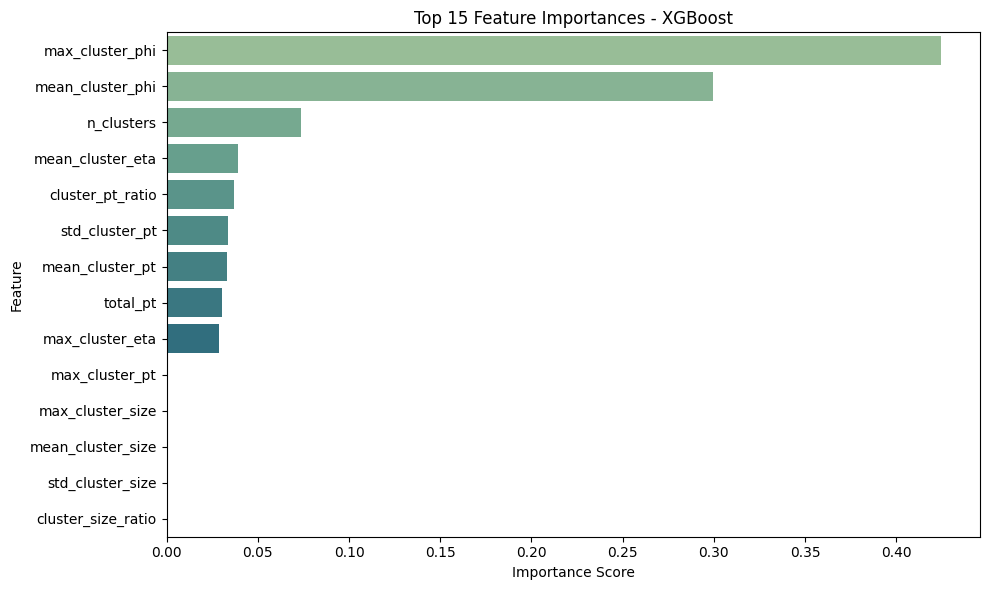

In [7]:
#feature importance plot

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df.head(15), x='importance', y='feature', palette='crest')
plt.title("Top 15 Feature Importances - XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Feature Engineering

In [8]:
# Log Transform of Total Transverse Momentum (total_pt)

'''
- total_pt is likely to be skewed — some events may have very high values.
- Log-transforming compresses these large values and makes the feature distribution more normal.
'''
X_train['log_total_pt'] = np.log1p(X_train['total_pt'])
X_val['log_total_pt'] = np.log1p(X_val['total_pt'])
X_test['log_total_pt'] = np.log1p(X_test['total_pt'])

In [9]:
# Log Transform of cluster_pt_ratio

'''
- cluster_pt_ratio is a ratio and may also be skewed.
- Applying log1p ensures we stabilize the variance and reduce the impact of extreme values.
'''
X_train['log_cluster_pt_ratio'] = np.log1p(X_train['cluster_pt_ratio'])
X_val['log_cluster_pt_ratio'] = np.log1p(X_val['cluster_pt_ratio'])
X_test['log_cluster_pt_ratio'] = np.log1p(X_test['cluster_pt_ratio'])

In [10]:
# Log Transform of cluster_size_ratio

'''
- Similar to cluster_pt_ratio, log-transform helps normalize the data range.
'''
X_train['log_cluster_size_ratio'] = np.log1p(X_train['cluster_size_ratio'])
X_val['log_cluster_size_ratio'] = np.log1p(X_val['cluster_size_ratio'])
X_test['log_cluster_size_ratio'] = np.log1p(X_test['cluster_size_ratio'])


In [11]:
# Normalize total_pt by number of clusters

'''
Feature: pt_per_cluster = total_pt / n_clusters
- This gives an idea of how much energy is concentrated per cluster.
- High pt_per_cluster may be indicative of boosted objects like top quarks.
'''
X_train['pt_per_cluster'] = X_train['total_pt'] / (X_train['n_clusters'] + 1e-5)
X_val['pt_per_cluster'] = X_val['total_pt'] / (X_val['n_clusters'] + 1e-5)
X_test['pt_per_cluster'] = X_test['total_pt'] / (X_test['n_clusters'] + 1e-5)


In [12]:
# Normalize cluster size by number of clusters

'''
Feature: size_per_cluster = mean_cluster_size / n_clusters
- Similar to pt, it tells us how big clusters are on average in a normalized way.
'''
X_train['size_per_cluster'] = X_train['mean_cluster_size'] / (X_train['n_clusters'] + 1e-5)
X_val['size_per_cluster'] = X_val['mean_cluster_size'] / (X_val['n_clusters'] + 1e-5)
X_test['size_per_cluster'] = X_test['mean_cluster_size'] / (X_test['n_clusters'] + 1e-5)


In [13]:
# Ratio between mean cluster pt and size

''' 
Feature: pt_size_ratio = mean_cluster_pt / mean_cluster_size
- Measures the average energy density per cluster.
- A high ratio could mean a more "collimated" or energetic jet.
'''
X_train['pt_size_ratio'] = X_train['mean_cluster_pt'] / (X_train['mean_cluster_size'] + 1e-5)
X_val['pt_size_ratio'] = X_val['mean_cluster_pt'] / (X_val['mean_cluster_size'] + 1e-5)
X_test['pt_size_ratio'] = X_test['mean_cluster_pt'] / (X_test['mean_cluster_size'] + 1e-5)


In [14]:
# Ratio between std deviation of pt and cluster size

'''
Feature: pt_size_std_ratio = std_cluster_pt / std_cluster_size
- Captures how variable the pt is relative to how variable the sizes are.
- Helps detect unstable or fragmented jets.
'''
X_train['pt_size_std_ratio'] = X_train['std_cluster_pt'] / (X_train['std_cluster_size'] + 1e-5)
X_val['pt_size_std_ratio'] = X_val['std_cluster_pt'] / (X_val['std_cluster_size'] + 1e-5)
X_test['pt_size_std_ratio'] = X_test['std_cluster_pt'] / (X_test['std_cluster_size'] + 1e-5)


In [15]:
# Angular spread in η–ϕ space

'''
Feature: eta_phi_spread = (max_eta - mean_eta) * (max_phi - mean_phi)
- This captures how spatially spread the jet is in angular space.
- ttbar jets may be more collimated (narrow), while QCD jets may be more diffuse.
'''
X_train['eta_phi_spread'] = (X_train['max_cluster_eta'] - X_train['mean_cluster_eta']) * \
                            (X_train['max_cluster_phi'] - X_train['mean_cluster_phi'])

X_val['eta_phi_spread'] = (X_val['max_cluster_eta'] - X_val['mean_cluster_eta']) * \
                          (X_val['max_cluster_phi'] - X_val['mean_cluster_phi'])

X_test['eta_phi_spread'] = (X_test['max_cluster_eta'] - X_test['mean_cluster_eta']) * \
                           (X_test['max_cluster_phi'] - X_test['mean_cluster_phi'])

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


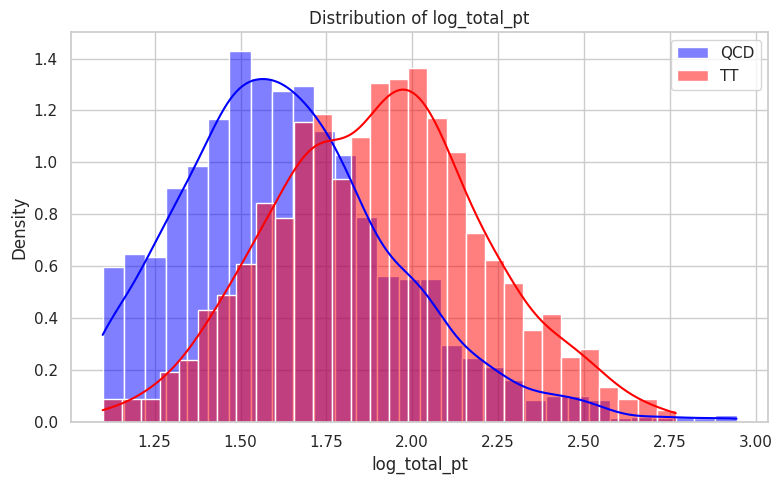

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


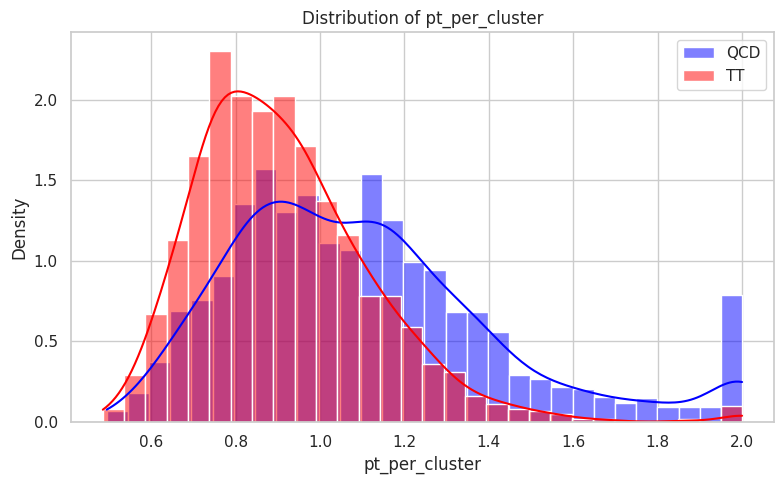

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


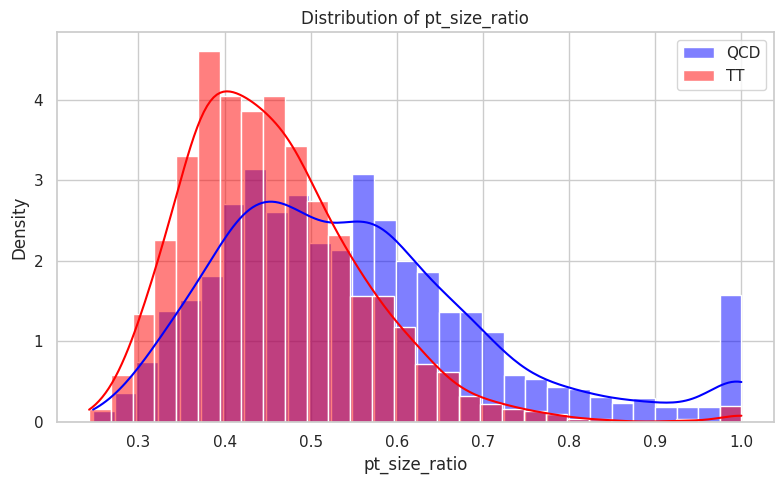

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


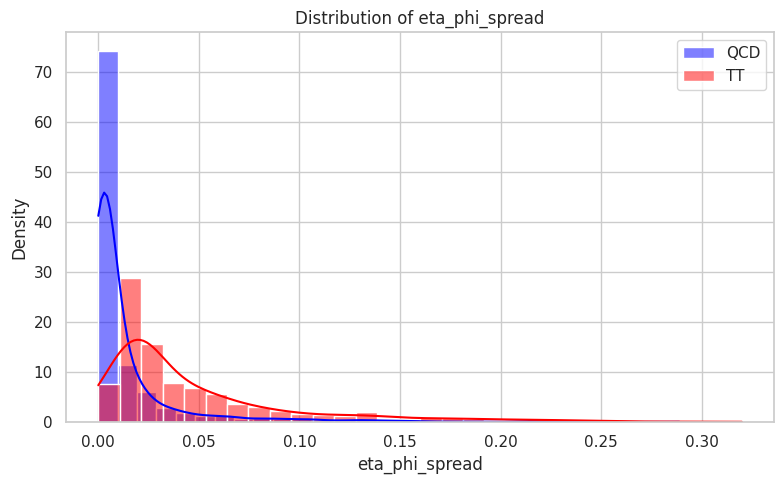

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


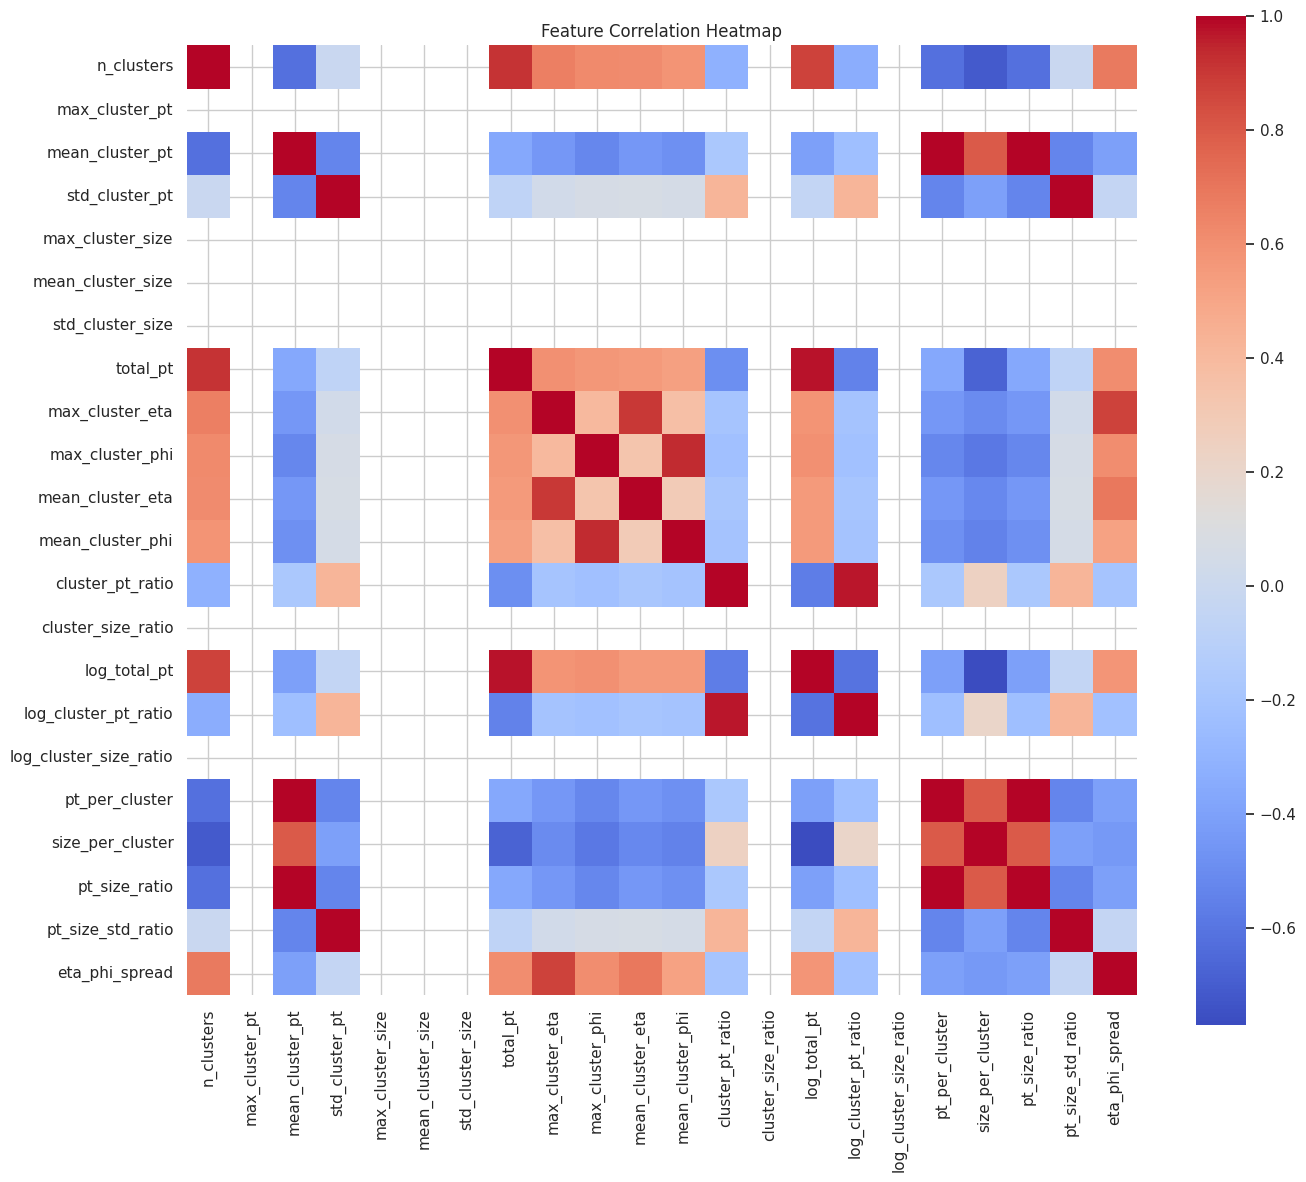

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# We'll visualize selected important engineered features:
# 1. log_total_pt
# 2. pt_per_cluster
# 3. pt_size_ratio
# 4. eta_phi_spread
# Each will be shown as a histogram split by label

# Set plot style
sns.set(style='whitegrid')

# Create a helper function for histograms
def plot_distribution_by_class(feature_name, bins=30):
    plt.figure(figsize=(8, 5))
    sns.histplot(X_train[feature_name][y_train == 0], label='QCD', color='blue', kde=True, stat='density', bins=bins)
    sns.histplot(X_train[feature_name][y_train == 1], label='TT', color='red', kde=True, stat='density', bins=bins)
    plt.title(f'Distribution of {feature_name}')
    plt.xlabel(feature_name)
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot distributions
plot_distribution_by_class('log_total_pt')
plot_distribution_by_class('pt_per_cluster')
plot_distribution_by_class('pt_size_ratio')
plot_distribution_by_class('eta_phi_spread')

# Correlation heatmap for all features
plt.figure(figsize=(14, 12))
sns.heatmap(X_train.corr(), cmap="coolwarm", annot=False, fmt=".2f", square=True)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()


In [17]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# Train the XGBoost model on engineered features
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

# Validate on X_val
val_preds = xgb.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, val_preds)
print(f"Validation AUC after feature engineering: {auc:.5f}")


Validation AUC after feature engineering: 0.93416


 96%|=================== | 3375/3520 [00:14<00:00]       

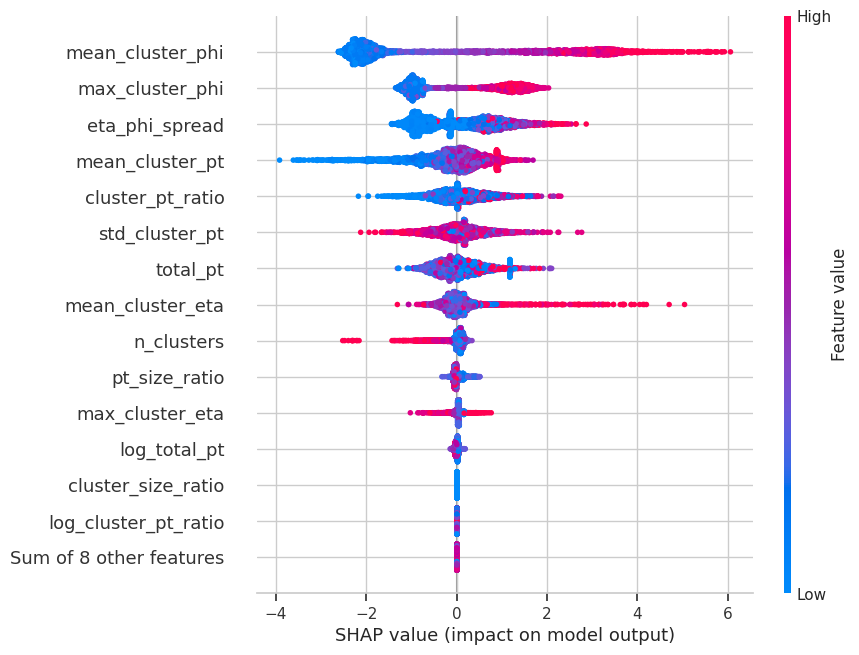

In [18]:
import shap

# Create SHAP explainer
explainer = shap.Explainer(xgb, X_train)
shap_values = explainer(X_train)

# SHAP summary plot: most important features and how they impact the model
shap.plots.beeswarm(shap_values, max_display=15)


In [19]:
import shap
import pandas as pd

# Get SHAP values again
explainer = shap.Explainer(xgb, X_train)
shap_values = explainer(X_train)

# Compute mean absolute SHAP value for each feature
shap_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': np.abs(shap_values.values).mean(axis=0)
}).sort_values(by='importance', ascending=False)

# Display top features
print("Top SHAP features:")
print(shap_importance.head(10))

# Choose number of features to drop
N = 5  # You can change this

# Get names of least important features
features_to_drop = shap_importance.tail(N)['feature'].tolist()
print(f"\nDropping bottom {N} features: {features_to_drop}")


 94%|=================== | 3315/3520 [00:14<00:00]       

Top SHAP features:
             feature  importance
11  mean_cluster_phi    2.222362
9    max_cluster_phi    1.054238
21    eta_phi_spread    0.745359
2    mean_cluster_pt    0.559787
12  cluster_pt_ratio    0.422886
3     std_cluster_pt    0.406357
7           total_pt    0.365246
10  mean_cluster_eta    0.284842
0         n_clusters    0.142832
19     pt_size_ratio    0.072895

Dropping bottom 5 features: ['log_cluster_pt_ratio', 'log_cluster_size_ratio', 'pt_per_cluster', 'size_per_cluster', 'pt_size_std_ratio']


In [20]:
# Drop from all datasets
X_train_reduced = X_train.drop(columns=features_to_drop)
X_val_reduced = X_val.drop(columns=features_to_drop)
X_test_reduced = X_test.drop(columns=features_to_drop)

# Retrain model
xgb_reduced = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_reduced.fit(X_train_reduced, y_train)

# Evaluate
val_preds_reduced = xgb_reduced.predict_proba(X_val_reduced)[:, 1]
auc_reduced = roc_auc_score(y_val, val_preds_reduced)
print(f"Validation AUC after dropping {N} features: {auc_reduced:.5f}")


Validation AUC after dropping 5 features: 0.93416


# Hyperparameter Tuning

In [21]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from scipy.stats import uniform, randint

# Define search space
param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(3, 8),
    'learning_rate': uniform(0.01, 0.1),
    'subsample': uniform(0.8, 0.2),
    'colsample_bytree': uniform(0.8, 0.2)
}

# Base model
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# RandomizedSearchCV setup
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    scoring='roc_auc',
    n_iter=30,              # Number of random combinations to try
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Run tuning on reduced feature set
random_search.fit(X_train_reduced, y_train)

# Best results
print("Best Parameters:", random_search.best_params_)
print("Best AUC from CV:", random_search.best_score_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'colsample_bytree': 0.8148089303468181, 'learning_rate': 0.04584657285442727, 'max_depth': 3, 'n_estimators': 127, 'subsample': 0.9726206851751188}
Best AUC from CV: 0.9404780249063361


In [22]:
# Final tuned model
best_params = {
    'colsample_bytree': 0.8148089303468181,
    'learning_rate': 0.04584657285442727,
    'max_depth': 3,
    'n_estimators': 127,
    'subsample': 0.9726206851751188,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'random_state': 42
}

# Train on full training set with reduced features
xgb_tuned = XGBClassifier(**best_params)
xgb_tuned.fit(X_train_reduced, y_train)

# Evaluate on validation set
val_preds_tuned = xgb_tuned.predict_proba(X_val_reduced)[:, 1]
auc_final = roc_auc_score(y_val, val_preds_tuned)
print(f"Validation AUC with tuned XGBoost: {auc_final:.5f}")


Validation AUC with tuned XGBoost: 0.94393


In [23]:
# Compute SHAP values again (if not already done)
explainer = shap.Explainer(xgb_tuned, X_train_reduced)
shap_values = explainer(X_train_reduced)

# Create SHAP importance summary (mean absolute value per feature)
import pandas as pd
shap_importance = pd.DataFrame({
    'feature': X_train_reduced.columns,
    'mean_abs_shap': np.abs(shap_values.values).mean(axis=0)
}).sort_values(by='mean_abs_shap', ascending=False)

# Display top features
print("Top SHAP-ranked features:")
print(shap_importance.head(15))

# Optionally save to CSV
shap_importance.to_csv("shap_feature_importance.csv", index=False)


Top SHAP-ranked features:
              feature  mean_abs_shap
11   mean_cluster_phi       1.383235
9     max_cluster_phi       0.871395
16     eta_phi_spread       0.292201
2     mean_cluster_pt       0.103949
10   mean_cluster_eta       0.101746
0          n_clusters       0.098999
7            total_pt       0.089315
3      std_cluster_pt       0.073391
12   cluster_pt_ratio       0.048159
15      pt_size_ratio       0.028772
8     max_cluster_eta       0.018701
14       log_total_pt       0.017633
6    std_cluster_size       0.000000
1      max_cluster_pt       0.000000
5   mean_cluster_size       0.000000


In [24]:
# Predict test probabilities
test_preds_tuned = xgb_tuned.predict_proba(X_test_reduced)[:, 1]

# Create submission DataFrame
submission = pd.DataFrame({
    'id': test_ids,
    'label': test_preds_tuned
})

# Save to CSV
submission.to_csv('submission.csv', index=False)
print("✅ Submission file saved: submission.csv")


✅ Submission file saved: submission.csv


In [25]:
# SUBMISSION

'''
xgb_test_preds = np.load('/kaggle/working/01_xgb_test_preds.npy')

xgb_submission = pd.DataFrame({
    'id': test_ids,
    'label': xgb_test_preds
})
xgb_submission.to_csv('/kaggle/working/submission.csv', index=False)
print("XGBoost submission saved: submission.csv")
'''

'\nxgb_test_preds = np.load(\'/kaggle/working/01_xgb_test_preds.npy\')\n\nxgb_submission = pd.DataFrame({\n    \'id\': test_ids,\n    \'label\': xgb_test_preds\n})\nxgb_submission.to_csv(\'/kaggle/working/submission.csv\', index=False)\nprint("XGBoost submission saved: submission.csv")\n'